In [1]:
import copy
import csv
import cvxpy
import datetime
import json
import math
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Pool
import numpy as np
import os
import pandas as pd
import pickle
import random
import seaborn as sns
from typing import List, Dict
import sys
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
sys.path.append('../')

from skyburst import Job
from skyburst.plot import *
from skyburst.traces import philly
from skyburst.traces import philly_utils

# NUM_GPUS per node: 8
GPUS_PER_NODE = 8

def load_logs(file_path: str):
    file = open(file_path)
    return pickle.load(file)

In [2]:
def create_results_df(simulator_results: dict):
    results_df = pd.DataFrame({'alg': pd.Series(dtype='str'),
                   'input_rate': pd.Series(dtype='int'),
                   'cost': pd.Series(dtype='float'),
                   'waiting_time': pd.Series(dtype='float')})
    algs = []
    num_nodes_list = []
    cloud_costs = []
    waiting_times = []
    for key, finished_jobs in simulator_results.items():
        token_list = key.split('-')
        if len(token_list)>0:
            alg =  '-'.join(token_list[:-1])
            input_rate = token_list[-1]
        else:
            alg = f'{token_list[0]}-{token_list[1]}'
            input_rate = token_list[2]
        input_rate = int(input_rate)
        cloud_cost = 0.0
        total_waiting_time = 0.0
        count = 0
        for idx in range(len(finished_jobs['idx'])):
            if idx < 2000 or idx > len(finished_jobs['idx']) - 2000:
                continue
            arrival = finished_jobs['arrival'][idx]
            start = finished_jobs['start'][idx]
            if finished_jobs['state'][idx] != 'LOCAL':
                runtime = finished_jobs['runtime'][idx]
                cloud_cost += finished_jobs['num_gpus'][idx] * runtime
                if finished_jobs['state'][idx] == 'FILTER-CLOUD':
                    total_waiting_time += start - arrival
                else:
                    deadline = finished_jobs['deadline'][idx]
                    total_waiting_time += deadline - runtime - arrival
            else:
                total_waiting_time += start - arrival
            count+=1
        avg_waiting_time = total_waiting_time / count
        df = pd.DataFrame(data={'alg': [alg], 'input_rate': [input_rate], 'cost': [cloud_cost], 'waiting_time': [avg_waiting_time]})
        results_df = pd.concat([results_df, df], ignore_index=True)
    return results_df

def plot_cost_and_waiting_graph(results_df, normalized=False, plot_twin=True):
    if plot_twin:
        fig, ax = plt.subplots()
        ax2 = ax.twinx()
    else:
        # Get current default figsize
        default_figsize = plt.rcParams.get('figure.figsize')
        # Set the new figsize as the default
        fix, (ax, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(2*default_figsize[0], 2*default_figsize[1]))

    x_axis = 'normalized_input_rate'
    results_df['normalized_input_rate'] = results_df['input_rate']*13.580799152777779/(64*8)
    label_x = 'Normalized Input Rate'
    
    for idx, (label, grp) in enumerate(results_df.groupby('alg')):
        a1 = grp.plot(x = x_axis, y = 'cost',ax = ax, marker='^', label = label, legend=None, xlabel=label_x, \
                ylabel='Cloud Price')
        if plot_twin:
            style = '--'
        else:
            style = None
        a2 = grp.plot(x = x_axis, y = 'waiting_time', ax = ax2, marker='v', label = label, legend=None, xlabel=label_x, \
                      ylabel = 'Avg. Waiting Time', style=style)
    ax.set_ylim(bottom=0.0)
    
    if plot_twin:
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, ncol=len(labels) + len(labels2), \
                  bbox_to_anchor=(0, 1.00, 1, 0.2), loc="upper left")
        ax.grid(True, which='both')
    else:
        lines, labels = ax.get_legend_handles_labels()
        ax.legend(lines, labels, ncol=len(labels), \
                  bbox_to_anchor=(0, 0.90, 1, 0.2), loc="upper left")
        ax.grid(True, which='both')
        ax2.grid(True, which='both')
    plt.show()  

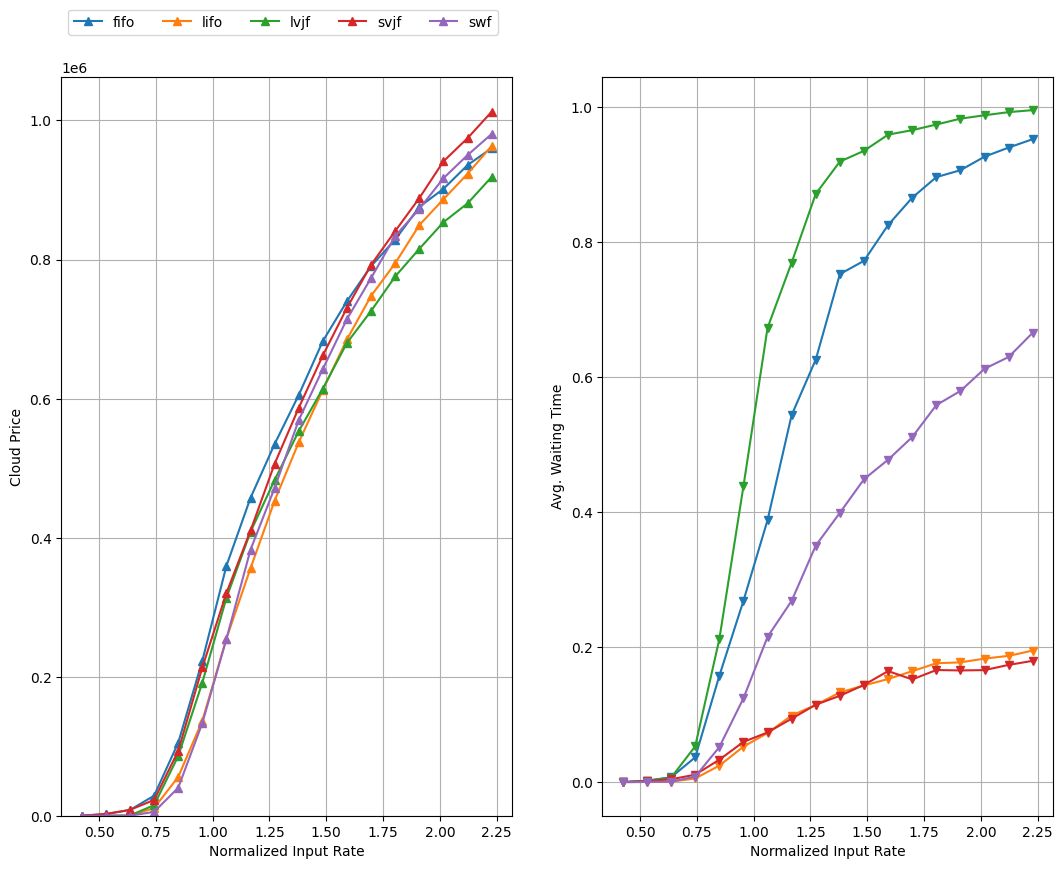

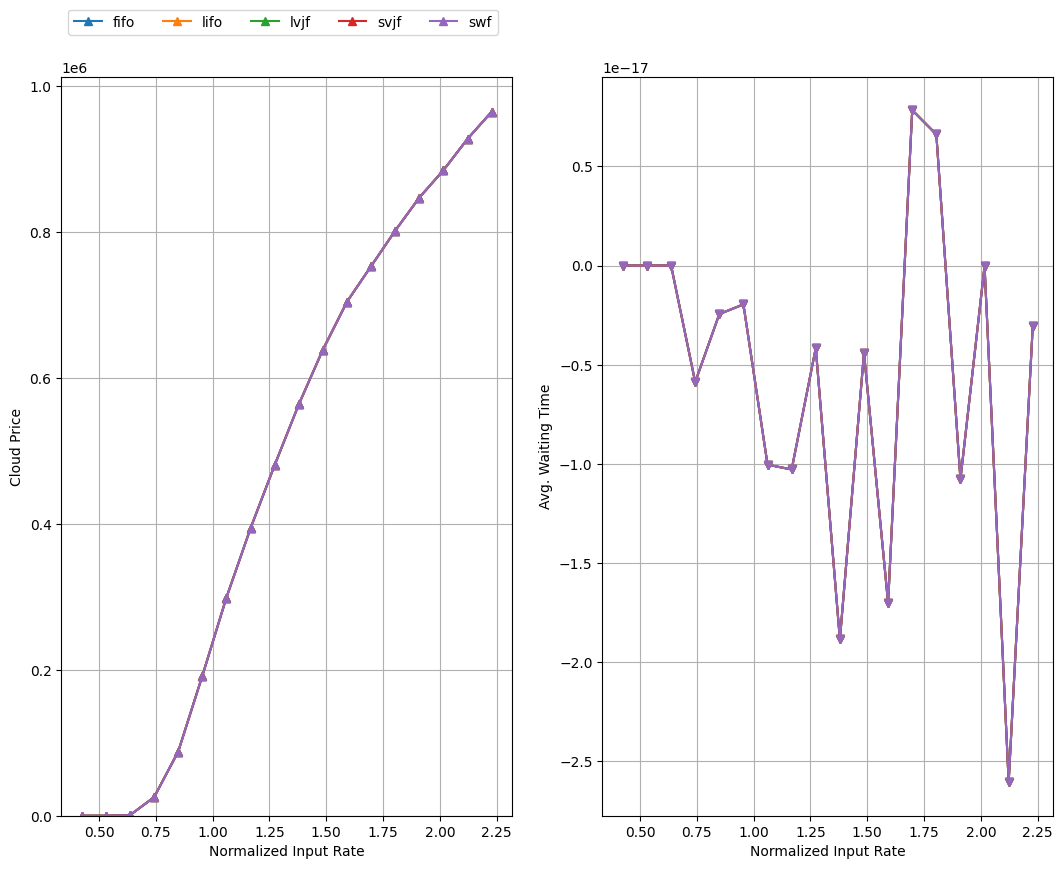

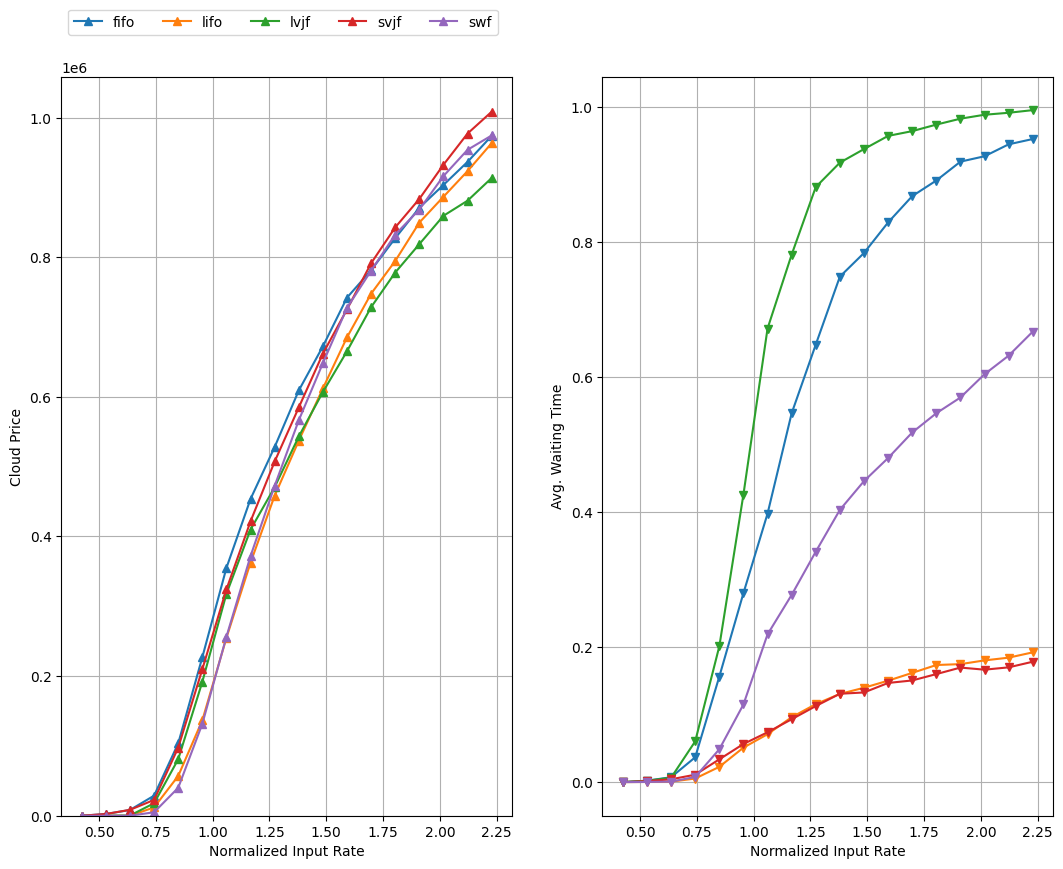

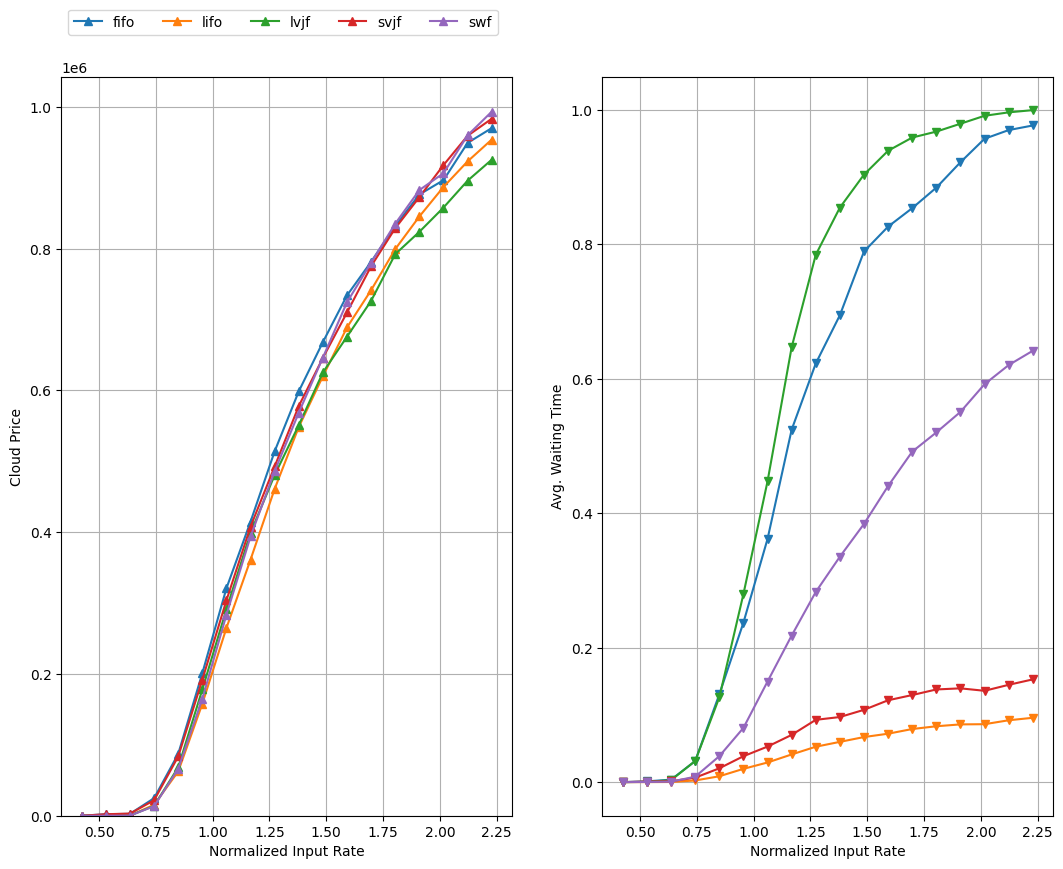

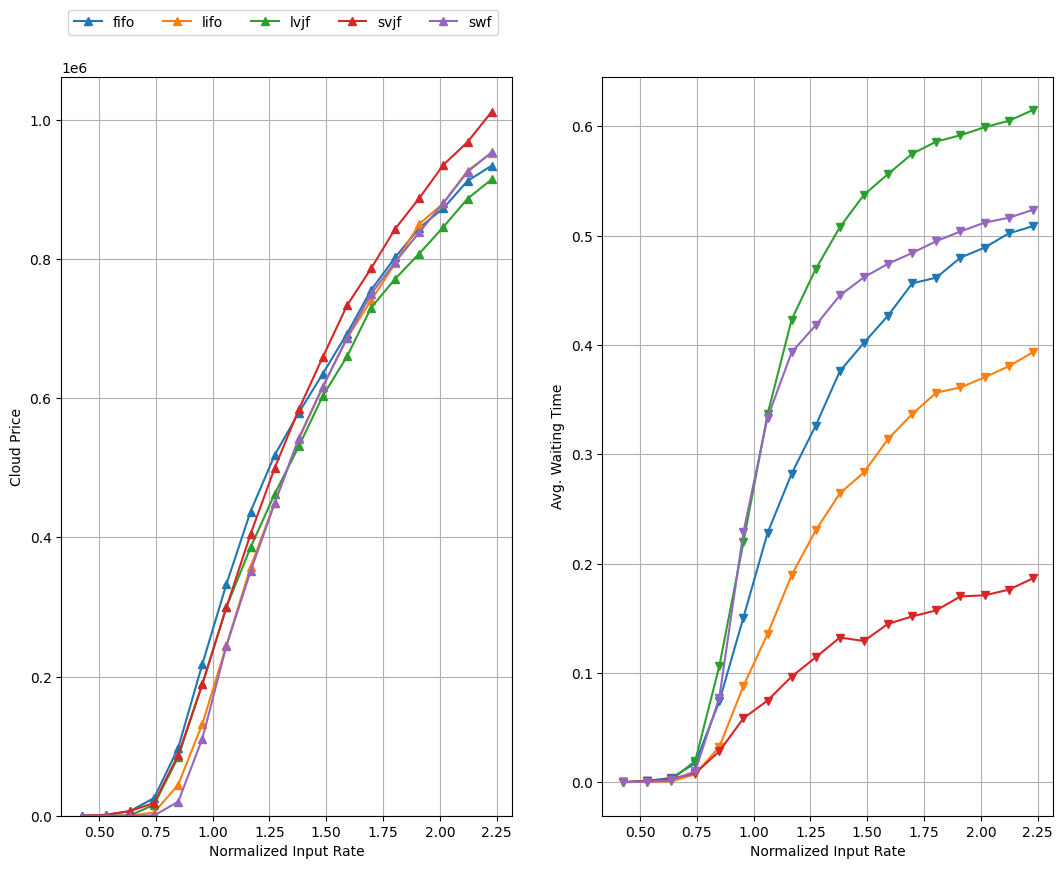

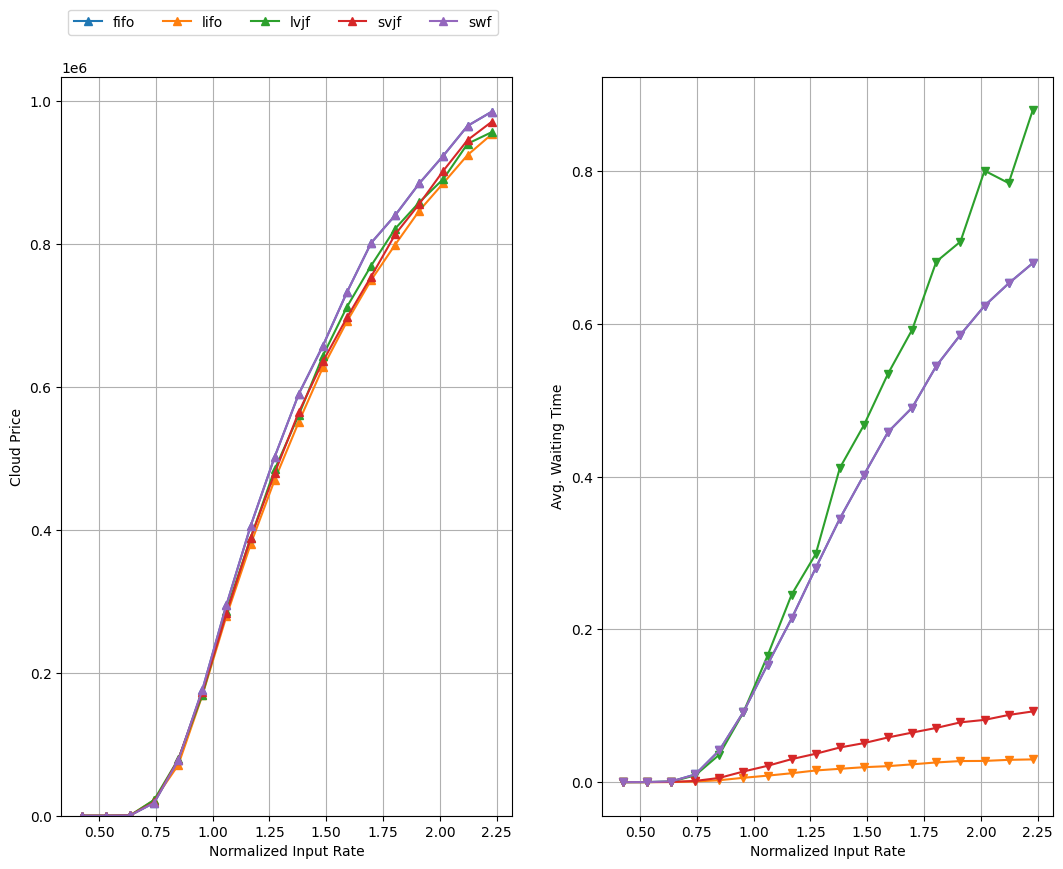

In [3]:

results={}
hybrid_results_df = pd.DataFrame()
for func_type in ['exact_log', 'nowait', 'linear', 'log', 'quad', 'constant']:
    num_nodes = 64
    file = open(f'logs/poisson/vary_capacity/{func_type}_philly_cont.log', 'rb')
    results[func_type] = pickle.load(file)
    temp_df = create_results_df(results[func_type])
    temp_df['deadline'] = func_type
    plot_cost_and_waiting_graph(temp_df, normalized=False, plot_twin=False)
    hybrid_results_df = pd.concat([hybrid_results_df, temp_df], ignore_index=True)

In [6]:
avg_job_volume_rate = np.mean(results['linear']['fifo-24']['num_gpus']* results['linear']['fifo-24']['runtime'])

/tmp/ipykernel_35352/1512212956.py:50: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.yaxis.grid(False, color='#DDDDDD')
/tmp/ipykernel_35352/1512212956.py:51: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.xaxis.grid(False, color='#DDDDDD')


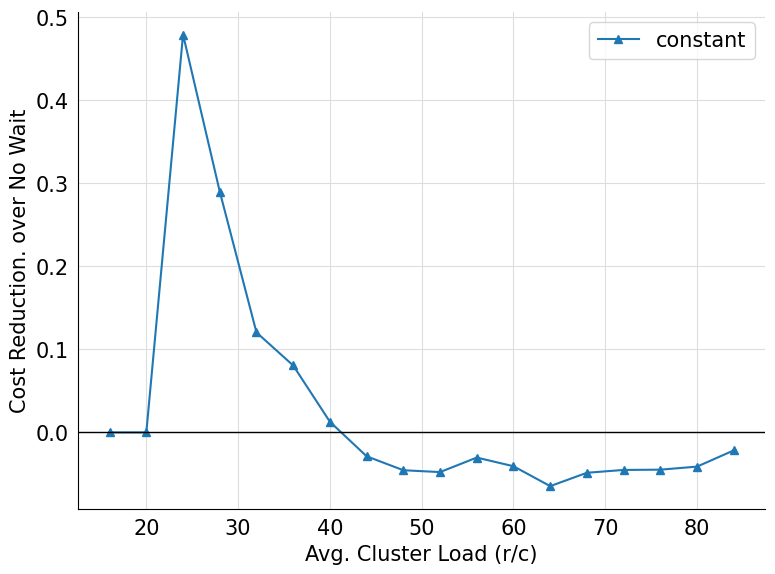

In [16]:
def plot_normalized_cost_deadline(results_df):
    fig, ax = plt.subplots(figsize=(8, 6))
    
#     total_job_gpu_hours = 1155998.77277777
#     job_makespan = 2559.3205555555555
#     results_df['normalized_input_rate'] = total_job_gpu_hours/(job_makespan*results_df['input_rate']*8)
    results_df['normalized_input_rate'] = results_df['input_rate']* avg_job_volume_rate/(64*8)
    results_df = results_df[results_df['alg']=='fifo']
    baseline_df =  results_df[results_df['deadline']=='nowait']

    #results_df = results_df[results_df['deadline']!='linear']
    results_df = results_df[results_df['deadline']=='constant']
    results_df = results_df[results_df['deadline']!='exact_log']
    #results_df = results_df[results_df['deadline']!='linear']
    #results_df = results_df[results_df['alg']!='fifo']
    
    diff_df = pd.merge(baseline_df,
               results_df, left_on=['input_rate', 'normalized_input_rate'],right_on=['input_rate', 'normalized_input_rate'])
    
    def cost_multiplier(row):
        baseline_cost = row['cost_x']
        cost = row['cost_y']
        #return baseline_cost - cost
        if baseline_cost == 0 and cost==0:
            return 0
        elif cost==0:
            return 1
        elif baseline_cost ==0:
            return -1
#         print(cost, baseline_cost)
        return max(-1, 1 - (cost/baseline_cost))
    
    diff_df['cost_diff'] = diff_df.apply(cost_multiplier, axis=1)
    plt.rcParams.update({'font.size': 15})
    for idx, (label, grp) in enumerate(diff_df.groupby('deadline_y')):
        a1 = grp.plot(x = 'normalized_input_rate', y = 'cost_diff',ax = ax, marker='^', label = label, legend=None, xlabel='Avg. Cluster Load (r/c)', \
                ylabel='Cost Reduction. over No Wait') # w(·)∝k
    lines, labels = ax.get_legend_handles_labels()
    ax.legend()
    #ax.legend(labels=['w(·)∝log(k)', 'w(·)∝k²'],loc='lower right')
    ax.axhline(linewidth=1, color="black")
    ax.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    #ax.spines['bottom'].set_color('#DDDDDD')
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.yaxis.grid(False, color='#DDDDDD')
    ax.xaxis.grid(False, color='#DDDDDD')
    
    fig.tight_layout()
    plt.savefig('figures/constant_ablate.pdf')
    
#     ax.legend(lines, labels, ncol=4, \
#               bbox_to_anchor=(0, 0.96, 1, 0.2), loc="center")
    #ax.grid(True, which='both')
    plt.show()

plot_normalized_cost_deadline(hybrid_results_df)

In [43]:
results.keys()

dict_keys(['exact_log', 'linear'])

/tmp/ipykernel_47317/2353494102.py:34: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax1.yaxis.grid(False, color='#EEEEEE')


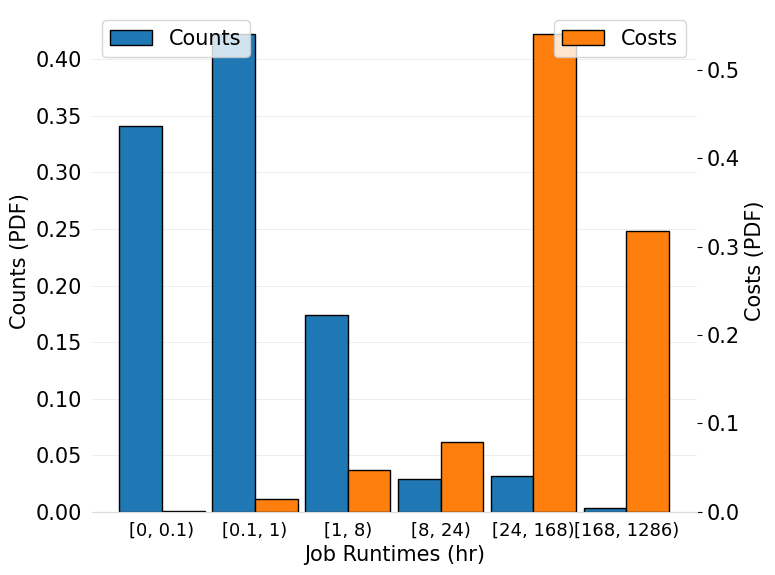

In [43]:
def plot_job_statistics(jobs, bins=None):
    jobs = copy.deepcopy(jobs)
    runtime = jobs['runtime']
    if bins is None:
        bins = [0, 0.1, 1, 8, 24, 168, math.ceil(max(runtime))]
    
    counts = [0] * (len(bins)-1)
    costs = [0] * (len(bins)-1)
    for job_idx, r in enumerate(runtime):
        for bin_idx in range(len(bins)-1):
            if r >= bins[bin_idx] and r < bins[bin_idx+1]:
                counts[bin_idx] +=1
                costs[bin_idx] += r * jobs['num_gpus'][job_idx]
    counts = [c/sum(counts) for c in counts]
    costs = [c/sum(costs) for c in costs]
    # Generated by ChatGPT
    bar_width = 0.46
    plt.rcParams.update({'font.size': 15})
    fig, ax1 = plt.subplots(figsize=(8, 6))
    ax2 = ax1.twinx()
    ax2.set_yticks([])
    
    ax1.grid(True)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_color('#DDDDDD')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['bottom'].set_color('#DDDDDD')
    ax1.tick_params(bottom=False, left=False)
    ax1.set_axisbelow(True)
    ax1.yaxis.grid(False, color='#EEEEEE')
    ax1.xaxis.grid(False)
    ax2.tick_params(bottom=True, left=False)
    ax2.set_axisbelow(True)
    ax2.xaxis.grid(False)
    
    
    x = np.arange(len(bins)-1)
    ax1.set_ylabel('Counts (PDF)')
    ax1.bar(x - bar_width/2, counts, width=bar_width, edgecolor='black', color='tab:blue')
    ax2.set_ylabel('Costs (PDF)')
    ax2.bar(x + bar_width/2, costs, width=bar_width, edgecolor='black', color='tab:orange')
    #ax1.set_yticks(np.arange(0, np.max(np.array(counts))+1, 10000))
    ax2.set_yticks(np.arange(0, np.max(np.array(costs)), 0.1))
    ax1.legend(['Counts'], loc='upper left')
    ax2.legend(['Costs'], loc='upper right')
    
    ax1.tick_params(axis='x', which='major', labelsize=13)
    #ax1.tick_params(axis='both', which='minor', labelsize=8)

    ax1.set_xlabel('Job Runtimes (hr)')
    # set the x-axis tick labels
    plt.xticks(x, [f'[{bins[bin_idx]}, {bins[bin_idx+1]})' for bin_idx in range(len(x))])
    # show the plot
    fig.tight_layout()
    plt.savefig('figures/philly_count_costs.pdf')
    plt.show()

plot_job_statistics(results['exact_log']['fifo-24'])

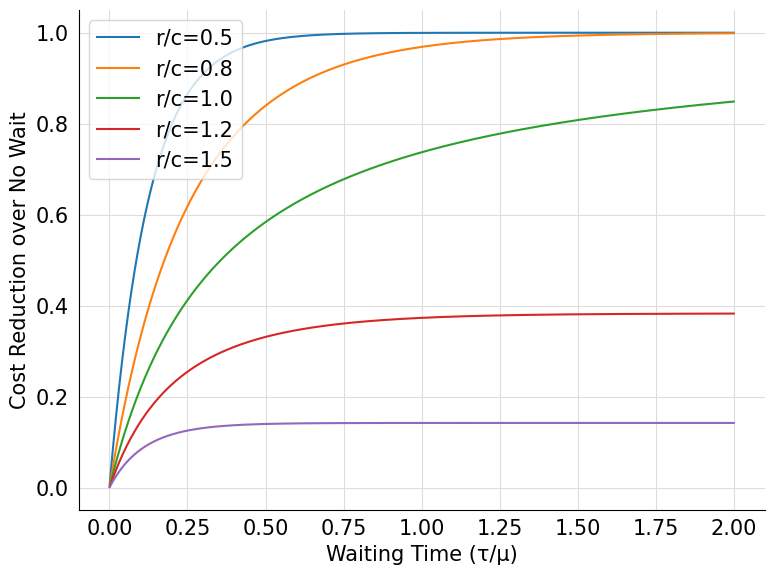

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial

def latex_formula(r, c, mu, tau):
    if r==c:
        numerator = (c**c / factorial(c)) * np.exp(-mu * tau * (c - r))
        denominator_sum = sum([(c**k / factorial(k)) for k in range(c)])
        last_term = (r**c / factorial(c)) * (1 + c*mu*tau)
        denominator = denominator_sum + last_term
        return numerator/denominator
    numerator = (r**c / factorial(c)) * np.exp(-mu * tau * (c - r))
    denominator_sum = sum([(r**k / factorial(k)) for k in range(c)])
    last_term = (r**c / factorial(c)) * (r * np.exp(-mu * tau * (c - r)) - c) / (r - c)
    denominator = denominator_sum + last_term
    return numerator / denominator

c = 16
mu = 1
r_values = np.linspace(0, 20, 1000)
tau_values = np.linspace(0.001, 2, 1000)
fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams.update({'font.size': 15})

ax.grid(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
#ax.spines['bottom'].set_color('#DDDDDD')
ax.spines['bottom'].set_visible(True)
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#DDDDDD')
ax.xaxis.grid(True, color='#DDDDDD')

for r in [c*0.5, c*0.8, c, c*1.2, c*1.5]: #, 16, 32]:
    y_values = [(latex_formula(r, c, mu, tau=0) - latex_formula(r, c, mu, tau=t*mu))/latex_formula(r, c, mu, tau=0)  for t in tau_values]
    plt.plot(tau_values, y_values, label=f'r/c={r/c}')
plt.legend()
    


plt.xlabel('Waiting Time (τ/μ)')
plt.ylabel('Cost Reduction over No Wait')

fig.tight_layout()
plt.savefig('figures/theoretical_cost_savings.pdf')
plt.show()